<table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Taller</p></tp>
            <tp><p style="font-size:150%;text-align:center">Implementación de Tableaux</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivos <a class="anchor" id="inicio"></a>

El objetivo de este notebook es implementar el algoritmo de construcción de tableros semánticos (tableaux). El método de los tableaux es un SATsolver, el cual recibe una fórmula y devuelve una interpretación de la misma, si es que existe, o informa que la fórmula es insatisfacible. Veremos diferentes maneras de implementar este método, dependiendo de distintas maneras de expandir el árbol del tableaux.


# Secciones

1. [Clasificación de fórmulas para tableaux.](#clas)
2. [Expansión primero en anchura.](#anchura)
3. [Expansión primero en profundidad.](#prof)
4. [Recorrido backtracking.](#backt)
5. [Eficiencia de los algoritmos (opcional).](#efi)

# Clasificación de fórmulas para tableaux <a class="anchor" id="clas"></a>

([Volver al inicio](#inicio))

Recordemos el siguiente diagrama de flujo para la implementación de un tableaux $\tau$ para una fórmula $A$:

<img src="./img/flow.png" width="auto"/>

Hay tres elementos centrales en este algoritmo:

* Nodos.
* Selección del próximo nodo a expandir.
* Clasificación de una fórmula como $\alpha$ o $\beta$.

En esta sección veremos la clasificación de fórmulas y la implementación de los nodos. En las subsiguientes secciones veremos tres maneras distintas de seleccionar el próximo nodo a expandir.

### Clasificación de una fórmula como $\alpha$ o $\beta$

Para realizar la implementación de los tableaux, el orden más apropiado es primero implementar la clasificación de fórmulas. Hemos visto que toda fórmula o es un literal, o puede clasificarse como una fórmula de tipo $\alpha$ o $\beta$. Para referencia, repetimos las clasificaciones en la siguiente figura:

<img src="./img/clasif.png" width="200px"/>

En el siguiente código hemos implementado la clasificación para dos casos: literales y fórmulas 1$\alpha$:

In [23]:
from Logica import *

In [24]:
def clasifica_para_tableaux(self):
    if type(self) == Letra:
        return None, 'literal'
    elif type(self) == Negacion:
        if type(self.subf) == Letra:
            return None, 'literal'
        elif type(self.subf) == Negacion:
            return 1, 'alfa'
        elif type(self.subf) == Binario:
            if self.subf.conectivo == 'O':
                return 3, 'alfa'
            elif self.subf.conectivo == '>':
                return 4, 'alfa'
            elif self.subf.conectivo == 'Y':
                return 1, 'beta'
    elif type(self) == Binario:
        if self.conectivo == 'Y':
            return 2, 'alfa'
        elif self.conectivo == 'O':
            return 2, 'beta'
        elif self.conectivo == '>':
            return 3, 'beta'

setattr(Formula,"clasifica_para_tableaux",clasifica_para_tableaux)

**Ejercicio 1:**

Complete la anterior función `clasifica_para_tableaux` para clasificar el resto de fórmulas de acuerdo a su tipo. Pruebe su implementación con las siguientes fórmulas:

In [25]:
f = '--(-(pOq)Y-(r>s))'  # 1, alfa
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

f = '(-(pOq)Y-(r>s))'  # 2, alfa
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

f = '-(pOq)'  # 3, alfa
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

f = '-(r>s)' # 4, alfa
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

f = '-(pYq)' # 1, beta
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

f = '(-(pYq)O(r>s))' # 2, beta
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

f = '(r>s)' # 3, beta
A = inorder_to_tree(f)
print(A.clasifica_para_tableaux())

(1, 'alfa')
(2, 'alfa')
(3, 'alfa')
(4, 'alfa')
(1, 'beta')
(2, 'beta')
(3, 'beta')


---

### Implementación de los nodos

El tableaux que vamos a implementar es un árbol basado en nodos. Los nodos son de la clase `nodos_tableaux` que se encuentra en la librería `Logica`. La descripción de la clase es la siguiente:

**Atributos:**

* `alfas`: una lista con las fórmulas tipo $\alpha$, representadas como una 4-tupla que incluye la fórmula como árbol, como cadena, el número de la regla y la cadena 'alfa'.
* `betas`: una lista con las fórmulas tipo $\beta$, representadas como una 4-tupla que incluye la fórmula como árbol, como cadena, el número de la regla y la cadena 'beta'.
* `literales`: una lista con los literales, representados como una 4-tupla que incluye la fórmula como árbol, como cadena, None y la cadena 'literal'.

**Métodos:**

* `tiene_lit_comp`: retorna `True` si self.`literales` tiene un par complementario de literales.
* `es_hoja`: retorna 'Cerrada' si self.`literales` tiene un par complementario de literales; 'Abierta' si self.`literales` NO tiene un par complementario de literales y no tiene reglas ni alfa ni beta; None en otro caso.
* `interp`: retorna un diccionario que hace veradero a todos los literales en self.`literales`.
* `expandir`: retorna un `nodo_tableaux` que es el resultado de aplicar la primera regla $\alpha$. Si no hay reglas $\alpha$, retorna dos `nodo_tableaux` que son el resultado de aplicar la primera regla $\beta$. Si no hay reglas $\beta$, retorna None, None.

Para ilustrar esta clase, instanciemos un objeto a partir de una fórmula $\alpha$, una $\beta$ y un literal:

In [26]:
print('Nodo n:')
forms = ['-(p>q)', '(pOq)', '-p']
forms = [inorder_to_tree(f) for f in forms]
n = nodos_tableaux(forms)
print(n)
print('')
print('¿Tiene literales complementarios?', n.tiene_lit_comp())
print('¿Es una hoja?', n.es_hoja())
print('Interpretación para literales:', n.interp())

Nodo n:
Alfas:['-(p>q)']
Betas:['(pOq)']
Literales:['-p']

¿Tiene literales complementarios? False
¿Es una hoja? None
Interpretación para literales: {'p': False}


El método `expandir` tomará la primera (y única en este caso) fórmula $\alpha$ y devolvera una lista [`None`, `n1`] donde `n1` es el nodo resultado de aplicar la regla:

In [27]:
hijos = n.expandir()
hijos

[<Logica.nodos_tableaux at 0x1ace0ab1df0>, None]

In [28]:
for hijo in hijos:
    if hijo != None:
        print(hijo)

Alfas:[]
Betas:['(pOq)']
Literales:['-p', 'p', '-q']


**Ejercicio 2:**

Expanda el hijo de `n` y verifique si los nodos resultado tienen pares complementarios de literales.

In [29]:
n1=hijos[0]
hijos=n1.expandir()
hijos

In [30]:
for hijo in hijos:
    if hijo != None:
        print(hijo)
        print("¿literales complementarios?", hijo.tiene_lit_comp())

Alfas:[]
Betas:[]
Literales:['-p', 'p', '-q']
¿literales complementarios? True
Alfas:[]
Betas:[]
Literales:['-p', 'p', '-q', 'q']
¿literales complementarios? True


---

**Ejercicio 3:**

Expanda manualmente (o mediante un while) el siguiente nodo hasta obtener solo una lista de literales y devuelva la interpretación que los hace verdaderos. Observe que todas sus subfórmulas son de tipo $\alpha$:

In [31]:
forms = ['--(-(pOq)Y-(r>s))']
forms = [inorder_to_tree(f) for f in forms]
n = nodos_tableaux(forms)

---

# Expansión primero en anchura <a class="anchor" id="anchura"></a>

([Volver al inicio](#inicio))

Ya tenemos los elementos necesarios para la generación del tableaux, pero necesitamos especificar una manera de ir expandiendo el árbol. Además de la opción de expandirlo de manera aleatoria -- seleccionando aleatoriamente un nodo que no sea una hoja -- tenemos tres opciones. En esta sección examinaremos la expansión primero en anchura. El pseudocódigo del algoritmo es el siguiente:

<img src="./img/anchura.png" width="350px"/>

La implementación en Python es la siguiente:

In [32]:
def primero_anchura(nodo):
    estado = nodo
    res = estado.es_hoja()
    if res == 'cerrada':
        return None
    elif res == 'abierta':
        return estado.interp()
    frontera = [estado]
    while len(frontera) > 0:
        estado = frontera.pop(0) 
        hijos = estado.expandir()
        for a in hijos:
            if a != None:
                res = a.es_hoja()
                if res == 'abierta':
                    return a.interp()
                elif res == None:
                    frontera.append(a)
    return None

Podemos usar esta función para expandir el nodo del ejercicio 3:

In [33]:
forms = ['--(-(pOq)Y-(r>s))']
forms = [inorder_to_tree(f) for f in forms]
n = nodos_tableaux(forms)
I = primero_anchura(n)
print("Resultado:", I)

Resultado: {'p': False, 'q': False, 'r': True, 's': False}


**Ejercicio 4:**

Expanda el nodo correspondiente a la siguiente fórmula:

'(((pYq)O(rOq))Y(-qO-p))'

Debe obtener la siguiente interpretación:

Resultado: {'q': False, 'r': True}

In [34]:
forms = ['(((pYq)O(rOq))Y(-qO-p))']
forms = [inorder_to_tree(f) for f in forms]
n = nodos_tableaux(forms)
I = primero_anchura(n)
print("Resultado:", I)

Resultado: {'q': False, 'r': True}


---

# Expansión primero en profundidad <a class="anchor" id="prof"></a>

([Volver al inicio](#inicio))

Además de poder expandir primero en anchura, podemos expandir primero en profundidad. El pseudocódigo de este algoritmo es el siguiente:

<img src="./img/profundidad.png" width="350px"/>

**Ejercicio 5:**

Implemente la función `primero_profundidad` y expanda los nodos para las siguientes fórmulas:

* '--(-(pOq)Y-(r>s))'
* '(((pYq)O(rOq))Y(-qO-p))'

Las soluciones deben ser las siguientes:

* Resultado: {'p': False, 'q': False, 'r': True, 's': False}
* Resultado: {'p': False, 'r': True}

In [35]:
def primero_profundidad(nodo):
    estado=nodo
    res=estado.es_hoja()
    if res=='cerrada':
        return None
    elif res=='abierta':
        return estado.interp()
    frontera=[estado]
    y=len(frontera)
    while y>0:
        estado=frontera.pop()
        hijos=estado.expandir()
        for a in hijos:
            if a!=None:
                res=a.es_hoja()
                if res=='abierta':
                    return a.interp()
                else:
                    frontera.append(a)
    return None
    
        

In [36]:
forms = ['--(-(pOq)Y-(r>s))']
forms = [inorder_to_tree(f) for f in forms]
n = nodos_tableaux(forms)
I = primero_profundidad(n)
print("Resultado:", I)


form = ['(((pYq)O(rOq))Y(-qO-p))']
form = [inorder_to_tree(f) for f in form]
m = nodos_tableaux(form)
J = primero_profundidad(m)
print("Resultado:", J)

Resultado: {'p': False, 'q': False, 'r': True, 's': False}
Resultado: {'p': False, 'r': True}


---

# Recorrido con backtracking <a class="anchor" id="backt"></a>

([Volver al inicio](#inicio))

Podemos hacer también un recorrido por el árbol haciendo una expansión recursiva que implementa el backtracking, como en el siguiente pseudocódigo:

<img src="./img/backtracking.png" width="350px"/>

**Ejercicio 6:**

Implemente la función `backtracking` y expanda los nodos para las siguientes fórmulas:

* '--(-(pOq)Y-(r>s))'
* '(((pYq)O(rOq))Y(-qO-p))'

Las soluciones deben ser las siguientes:

* Resultado: {'p': False, 'q': False, 'r': True, 's': False}
* Resultado: {'q': False, 'r': True}

In [37]:
def backtracking(nodo):
    estado = nodo
    res = estado.es_hoja()
    if res == 'cerrada':
        return None
    elif res == 'abierta':
        return estado.interp()
    hijos = estado.expandir()
    for a in hijos:
        if a != None:
            resultado = backtracking(a)
        if resultado is not None:
            return resultado    
    return None
    

In [38]:
forms = ['--(-(pOq)Y-(r>s))']
forms = [inorder_to_tree(f) for f in forms]
n = nodos_tableaux(forms)
I = backtracking(n)
print("Resultado:", I)


forms = ['(((pYq)O(rOq))Y(-qO-p))']
forms = [inorder_to_tree(f) for f in forms]
m = nodos_tableaux(forms)
J = backtracking(m)
print("Resultado:", J)

Resultado: {'p': False, 'q': False, 'r': True, 's': False}
Resultado: {'q': False, 'r': True}


---

# Sección opcional: Eficiencia de los algoritmos <a class="anchor" id="efi"></a>


([Volver al inicio](#inicio))

Vamos a verificar empíricamente cuál función es más rápida para expandir el árbol del tableaux de una fórmula dada. Para ello, crearemos fórmulas más y más grandes para probar en ellas nuestros tres algoritmos.

Definimos nuestras funciones para medir tiempos en una lista de entradas: 

In [39]:
from time import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def obtiene_tiempos(fun, args, num_it=100):
    tiempos_fun = []
    for i in range(num_it):
        arranca = time()
        x = fun(*args)
        para = time()
        tiempos_fun.append(para - arranca)
    return tiempos_fun

def compara_entradas_funs(funs, nombres_funs, lista_args, N=100):
    entradas = []
    funcion = []
    tiempos = []
    lista_dfs = []
    for i, args in enumerate(lista_args):
        for j, fun in enumerate(funs):
            t = obtiene_tiempos(fun, [args], N)
            tiempos += t
            n = len(t)
            entradas += [i+1]*n
            funcion += [nombres_funs[j]]*n
        df = pd.DataFrame({'Long_entrada':entradas, 
                           'Funcion':funcion,
                           'Tiempo_prom':tiempos})
        lista_dfs.append(df)
    df = pd.concat(lista_dfs)
    sns.lineplot(x='Long_entrada',y='Tiempo_prom',hue='Funcion',data=df)
    plt.show()

Creamos nuestra lista de fórmulas:

In [40]:
from random import uniform, choice

cantidad = 20
letras = [chr(i) for i in range(256, 256+cantidad)]
lista = [letras[0]]
formula = letras[0]
for p in letras[1:]:
    neg1 = '-' if uniform(0,1) > .5 else ''
    neg2 = '-' if uniform(0,1) > .5 else ''
    conectivo = choice(['Y','O','>'])
    formula = neg2 + "(" + formula + conectivo + neg1 + p + ")"
    lista.append(formula)

#lista

Y, finalmente, medimos los tiempos de ejecución para cada fórmula:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

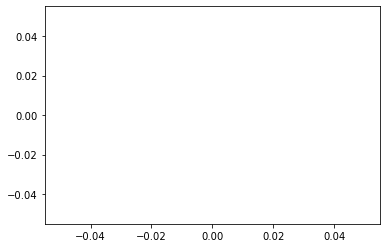

In [41]:
nombres = ['primero anchura', 'primero profundidad', 'backtracking']
anchura = lambda formula: primero_anchura(nodos_tableaux([inorder_to_tree(formula)]))
profundidad = lambda formula: primero_profundidad(nodos_tableaux([inorder_to_tree(formula)]))
backtrack = lambda formula: backtracking(nodos_tableaux([inorder_to_tree(formula)]))
funs = [anchura, profundidad, backtrack]
compara_entradas_funs(funs, nombres, lista)

En esta gráfica es muy fácil apreciar que, a medida que aumentamos el número de letras proposicionales distintas en la fórmula de entrada, los tres algoritmos se tardan más en determinar si ella es satisfacible. De los tres algoritmos, el peor es el de backtracking y el mejor es el de primero en profundidad. No obstante, vemos que el número de letras proposicionales no es el único factor que influye en el tiempo de ejecución. También influye la estructura de la fórmula. Más adelante estudiaremos el comportamiento de los algoritmos de acuerdo a distintos tipos de fórmulas.

---